In [1]:
# Setting up the notebook. 

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Dictionary mapping feature names to their descriptions
feature_descriptions = {
    'mean_radius': "Average distance from the center to the outer edge of the tumor.",
    'mean_texture': "How rough or smooth the surface of the tumor feels, on average.",
    'mean_perimeter': "The average length of the outline of the tumor.",
    'mean_area': "The average size of the surface of the tumor measured in square units.",
    'mean_smoothness': "How smooth or bumpy the tumor surface feels, averaged over several observations.",
    'mean_compactness': "A measure of how tightly the tumor cells are packed together, averaged over several observations.",
    'mean_concavity': "Average number of indentations or hollow areas on the tumor's surface.",
    'mean_concave_points': "Average number of sharp dips or points found along the contour of the tumor.",
    'mean_symmetry': "How evenly shaped the tumor is. A perfectly symmetrical tumor looks the same on both sides.",
    'mean_fractal_dimension': "A measure that describes the complexity of the tumor shape, showing how jagged the border is on average.",
    'radius_error': "The change in the tumor's radius across different measurements, indicating how much the size of the tumor varies.",
    'texture_error': "The change in the tumor's texture across different measurements, showing how much the roughness or smoothness varies.",
    'perimeter_error': "The change in the outline length of the tumor across different measurements, showing how much the outline varies.",
    'area_error': "The change in the surface size of the tumor across different measurements, showing how much the area varies.",
    'smoothness_error': "The change in how smooth or bumpy the tumor surface feels across different measurements.",
    'compactness_error': "The change in how tightly the tumor cells are packed together across different measurements.",
    'concavity_error': "The change in the number of indentations or hollow areas on the tumor's surface across different measurements.",
    'concave_points_error': "The change in the number of sharp dips or points found along the contour of the tumor across different measurements.",
    'symmetry_error': "The change in how evenly shaped the tumor is across different measurements.",
    'fractal_dimension_error': "The change in the complexity of the tumor shape across different measurements, showing how much the jaggedness of the border varies.",
    'worst_radius': "The largest distance from the center to the outer edge of the tumor observed among all measurements.",
    'worst_texture': "The roughest texture observed on the surface of the tumor.",
    'worst_perimeter': "The longest outline of the tumor measured among all observations.",
    'worst_area': "The largest surface area of the tumor measured among all observations.",
    'worst_smoothness': "The least smooth texture observed on the tumor's surface, indicating the roughest feel.",
    'worst_compactness': "The highest degree of how tightly the tumor cells are packed together, observed among all measurements.",
    'worst_concavity': "The deepest indentations observed on the tumor's surface.",
    'worst_concave_points': "The highest number of sharp dips or points observed along the contour of the tumor.",
    'worst_symmetry': "The most uneven shape observed in the tumor, where one side differs the most from the other.",
    'worst_fractal_dimension': "The highest complexity of the tumor shape observed, showing the most jagged border among all measurements."
}

def scatter_plot(X, y=None, line_plot=None, title='', show_legend=True, xlabel='', ylabel=''):
    """
    Create a scatter plot with optional labels, decision boundary, and filled areas.

    Parameters:
    X (dict): The data for the first class with keys 'data', 'color', and 'label'.
    y (dict, optional): The data for the second class with keys 'data', 'color', and 'label'.
    line_plot (dict, optional): The line plot details with keys 'x', 'y', 'color', 'linestyle', 'fill_colors', and 'model'.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    ylim (tuple, optional): The limits for the y-axis.
    show_legend (bool, optional): Whether to show the legend.
    """
    plt.figure(figsize=(8, 6))

    # Plotting the data points for X
    plt.scatter(X['data'][0], X['data'][1], color=X['color'], label=X["label"], edgecolors='k')
    
    # Plotting the data points for y, if provided
    if y is not None:
        plt.scatter(y['data'][0], y['data'][1], color=y['color'], label=y["label"], edgecolors='k')

    # Determining the ylim
    all_y_values = X['data'][1]
    if y is not None:
        all_y_values = np.concatenate([all_y_values, y['data'][1]])
    # if line_plot is not None:
    #     all_y_values = np.concatenate([all_y_values, line_plot["y"]])

    y_min, y_max = all_y_values.min(), all_y_values.max()
    y_range = y_max - y_min
    y_extension = y_range * 0.1  # 10% extension
    ylim = y_min - y_extension, y_max + y_extension
    plt.ylim(ylim)

    # Plotting the line plot
    if line_plot is not None:
        plt.plot(line_plot['x'], line_plot['y'], color=line_plot['color'], linestyle=line_plot['linestyle'], label='Decision Boundary')

        if 'fill_colors' in line_plot and ylim is not None:
            point_above = np.array([[line_plot['x'][0], line_plot['y'][0] + 1]])
            prediction_above = line_plot['model'].predict(point_above) if 'model' in line_plot else None

            if prediction_above == 1:
                plt.fill_between(line_plot['x'], line_plot['y'], ylim[1], color=line_plot['fill_colors'][1], alpha=0.2)
                plt.fill_between(line_plot['x'], ylim[0], line_plot['y'], color=line_plot['fill_colors'][0], alpha=0.2)
            else:
                plt.fill_between(line_plot['x'], line_plot['y'], ylim[1], color=line_plot['fill_colors'][0], alpha=0.2)
                plt.fill_between(line_plot['x'], ylim[0], line_plot['y'], color=line_plot['fill_colors'][1], alpha=0.2)

    # Setting the plot title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if show_legend and (X['label'] or (y and y['label'])):
        plt.legend()
    
    plt.show()

In [ ]:
### KNN Regressor Training:

# Generate some made-up data
np.random.seed(0)
temperatures = np.random.uniform(60, 100, 500)  # Randomly choose temperatures between 60 and 100 degrees
ice_cream_sales = temperatures * 1.5 + np.random.normal(0, 10, 500)  # Randomly (kinda) choose sales made. ice_cream_sales.shape = (500,)

# Reshape the temperatures for sklearn
temperatures_reshaped = temperatures.reshape(-1, 1)   # -1 represents the an unknown number that reshape will calculate based on the other dimension, which is 1 in this case. temperatures_reshaped.shape = (500, 1)

# train/split the data
temperatures_train, temperatures_test, ice_cream_sales_train, ice_cream_sales_test = train_test_split(
    temperatures_reshaped, ice_cream_sales, train_size=0.75, random_state=0
)
temperatures_test = pd.DataFrame(temperatures_test)  # Convert to DataFrame for consistency with the rest of the code

# Shapes of the train and test sets
#temperatures_train.shape,  temperatures_test.shape,    ice_cream_sales_train.shape,    ice_cream_sales_test.shape
#(375, 1),                  (125, 1),                   (375,),                         (125,)

# Initialize K-NN regressor
knn_regressor = KNeighborsRegressor()

# Define parameter grid for GridSearchCV
param_grid = {
    "n_neighbors": range(1, 202, 2),
}

# Initialize and fit GridSearchCV
temp_gridsearch = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=10,
    scoring="neg_root_mean_squared_error"
)

temp_gridsearch.fit(temperatures_train, ice_cream_sales_train)

# Retrieve and format results
results = pd.DataFrame(temp_gridsearch.cv_results_)     # After fitting the model, we extract the cross-validation results using `cv_results_`. This output includes various metrics and parameters tested during the cross-validation process.
results = (
    results[[
        "param_n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_n_neighbors": "n_neighbors"})
) # we specify the scoring metric as "neg_root_mean_squared_error" to evaluate the model performance based on RMSPE.
# results.shape = 101 rows x 2 columns

results["mean_test_score"] = -results["mean_test_score"]
# could also code this as results["mean_test_score"] = results["mean_test_score"].abs()

results.nsmallest(1, 'mean_test_score')  
# row	n_neighbors	    mean_test_score
# 25	51	            9.797858

temp_gridsearch.best_params_        # {'n_neighbors': 51}



<class 'pandas.core.frame.DataFrame'>


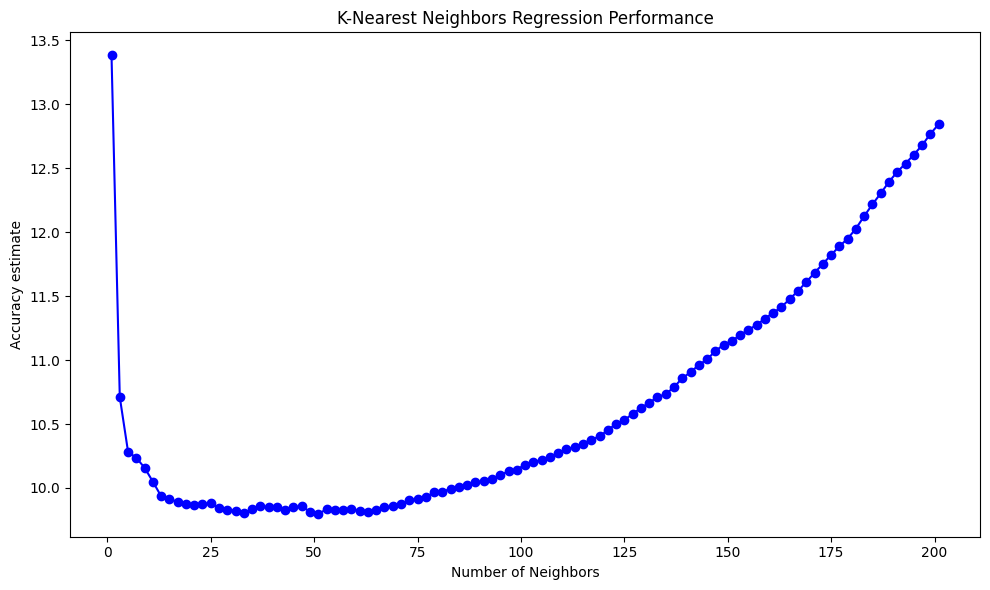

In [36]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean test scores with error bars
plt.plot(results['n_neighbors'], results['mean_test_score'], '-o', color='blue')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy estimate')
plt.title('K-Nearest Neighbors Regression Performance')
plt.tight_layout()
plt.show()

In [37]:
# Model Evaluation
# Make predictions on the test set
temperatures_test["predicted"] = temp_gridsearch.predict(temperatures_test[[0]])

# Calculate RMSPE
rmspe = mean_squared_error(
    y_true=ice_cream_sales_test,
    y_pred=temperatures_test["predicted"]
)**0.5

rmspe

10.29827691053499

In [38]:
# Calculate R² 
r2 = r2_score( 
y_true=ice_cream_sales_test, y_pred=temperatures_test["predicted"] 
)

r2

0.7027127970781057

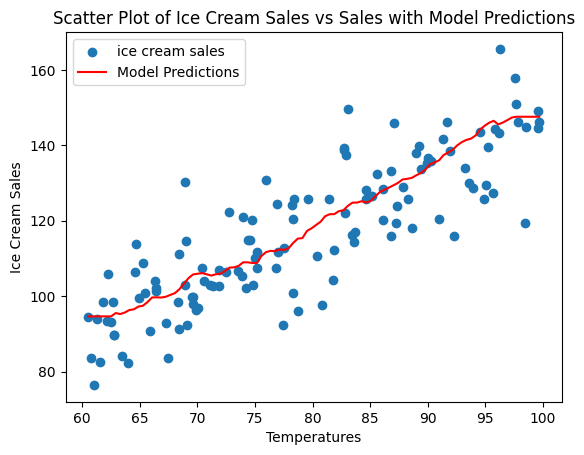

In [39]:
# Generate a range of temperatures for prediction
temps = np.linspace(temperatures_test[[0]].min(), temperatures_test[[0]].max(), 100).reshape(-1, 1)

# Predict ice cream sales from temperatures using the best model from GridSearchCV
predicted_ice_cream_sales = temp_gridsearch.predict(temps)

# Plot the original data
plt.scatter(temperatures_test[[0]], ice_cream_sales_test, label="ice cream sales")

# Plot the model predictions as a line
plt.plot(temps, predicted_ice_cream_sales, color='red', label="Model Predictions")

# Add labels and legend
plt.xlabel("Temperatures")
plt.ylabel("Ice Cream Sales")
plt.title("Scatter Plot of Ice Cream Sales vs Sales with Model Predictions")
plt.legend()
plt.show();